In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import numpy as np

In [111]:
def bootstrap_gen(dataframe):
    return dataframe.sample(frac=1,replace=True)
def CVratio(experimentdata):
    return (experimentdata["<y>"].std(ddof=0)/experimentdata["<y>"].mean())/(experimentdata["<x>"].std(ddof=0)/experimentdata["<x>"].mean())
def xycorr(experimentdata):
    return experimentdata["<x>"].corr(experimentdata["<y>"])
def bootstrap_stderr_mean(experimentdata,f,n):
    bootstrap_fs = [f(bootstrap_gen(experimentdata)) for i in range(n)]
    return np.std(bootstrap_fs,ddof=0)/np.sqrt(len(experimentdata)),np.mean(bootstrap_fs)
def joinedbootstrap(experimentdata,n):
    rhos = []
    Cs = []
    for i in range(n):
        sample = bootstrap_gen(experimentdata)
        rhos.append(xycorr(sample))
        Cs.append(CVratio(sample))
    return np.std(rhos),np.std(Cs)


In [112]:
files = glob.glob('no_fb_sims_largerange_2023-02-02/*_simresults.tsv')
dfs = list()
for f in files:
    data = pd.read_csv(f,sep='\t')
    data['file'] = ''.join(x for x in f[35:] if x.isdigit())
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [113]:
byfile = df[["<x>","<y>","file"]].groupby("file")

In [114]:
cols = ["file","C","rho","std_rho","std_C","mean_rho","mean_C"]
pertdata = pd.DataFrame(columns=cols)
excluded = ["4"]
for number in df['file'].unique():
    if number not in excluded:
        #isolate data by parameter set
        experimentdata = df[df["file"] == number]
        #calculate quantity
        rho = xycorr(experimentdata)
        C_val = CVratio(experimentdata)
        #estimate standard error by bootstrapping
        std_rho,mean_rho = bootstrap_stderr_mean(experimentdata,xycorr,1000)
        std_Cval,mean_Cval = bootstrap_stderr_mean(experimentdata,CVratio,1000)

        df2 = pd.DataFrame([[number,C_val,rho,std_rho,std_Cval,mean_rho,mean_Cval]], columns= cols)
        pertdata = pd.concat([pertdata,df2])

<AxesSubplot:xlabel='mean_C', ylabel='mean_rho'>

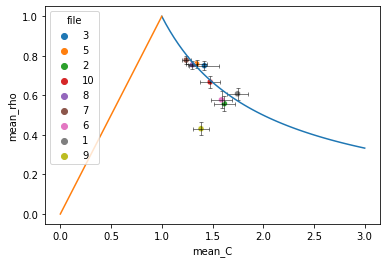

In [115]:

plt.errorbar(y="mean_rho", x="mean_C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=pertdata, label=None, capsize=2, capthick=0.5,color='k',fmt='none')

plt.plot(np.linspace(1,3),1/np.linspace(1,3))
plt.plot(np.linspace(0,1),np.linspace(0,1))
sns.scatterplot(data=pertdata,x="mean_C",y="mean_rho",hue="file")

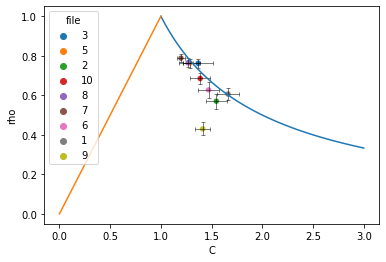

In [116]:
sns.scatterplot(data=pertdata,x="C",y="rho",hue="file")
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=pertdata, label=None, capsize=2, capthick=0.5,color='k',fmt='none')
plt.plot(np.linspace(1,3),1/np.linspace(1,3))
plt.plot(np.linspace(0,1),np.linspace(0,1))

In [117]:
pertdata

,file,C,rho,std_rho,std_C,mean_rho,mean_C
0,3,1.367661,0.761936,0.022835,0.146804,0.750407,1.420016
0,5,1.284628,0.762393,0.021977,0.10172,0.759416,1.342796
0,2,1.546516,0.570246,0.038677,0.103183,0.55833,1.616486
0,10,1.387427,0.685305,0.029867,0.097758,0.667815,1.476972
0,8,1.267903,0.764986,0.02165,0.04705,0.754784,1.302146
0,7,1.197926,0.788144,0.020853,0.042504,0.778528,1.240675
0,6,1.470847,0.627268,0.042551,0.102235,0.577672,1.588705
0,1,1.661698,0.606726,0.030084,0.103576,0.608109,1.746631
0,9,1.411745,0.429879,0.032858,0.076706,0.431472,1.386603


20

1.8902380802428036